In [ ]:
# DenseNet - OCTID - 5CV
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Paths
dataset_base_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/dataset split/OCTID_Splits"
logs_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/denseNet/octid/training"
models_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/denseNet/octid/models"
results_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/denseNet/octid/results"

# Ensure directories exist
os.makedirs(models_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

# Model parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-4

# Function to create Data Generators
def get_generators(set_path):
    train_dir = os.path.join(set_path, "train")
    val_dir = os.path.join(set_path, "validation")
    test_dir = os.path.join(set_path, "test")
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
    )
    val_gen = val_test_datagen.flow_from_directory(
        val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
    )
    test_gen = val_test_datagen.flow_from_directory(
        test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
    )
    
    return train_gen, val_gen, test_gen

# Function to build DenseNet model
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze initial layers
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(5, activation='softmax')(x)  # Fixed output layer (5 classes, softmax)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )
    return model

# Training and evaluation loop
all_results = []

for i in range(1, 6):
    print(f"Training on Set {i}...")
    set_path = os.path.join(dataset_base_path, f"OCTID_Set_{i}")
    train_gen, val_gen, test_gen = get_generators(set_path)
    
    model = build_model()
    
    # Callbacks
    model_checkpoint = ModelCheckpoint(
        os.path.join(models_path, f'densenet_set{i}.h5'), save_best_only=True, monitor='val_loss', mode='min'
    )
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
    csv_logger = CSVLogger(os.path.join(logs_path, f'training_log_set{i}.csv'))
    
    # Train model
    history = model.fit(
        train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=[model_checkpoint, early_stopping, reduce_lr, csv_logger]
    )
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Set {i} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    
    # Predictions
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Fix: Convert softmax output to class labels
    
    # Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(os.path.join(results_path, f'results_set{i}.csv'))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Set {i}')
    plt.savefig(os.path.join(results_path, f'confusion_matrix_set{i}.png'))
    plt.close()
    
    # Store results
    all_results.append({
        'Set': i,
        'Test Accuracy': test_acc,
        'Test Loss': test_loss,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    })

# Save all results to Excel
df_all_results = pd.DataFrame(all_results)
df_all_results.to_excel(os.path.join(results_path, 'densenet_octid_results.xlsx'), index=False)

print("Training and evaluation complete!")


========== Training on Fold 1 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-04-01 04:20:21.153648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.1902 - loss: 0.5386 
Epoch 1: val_loss improved from inf to 0.30117, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 34s/step - accuracy: 0.1912 - loss: 0.5294 - val_accuracy: 0.3913 - val_loss: 0.3012
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.1727 - loss: 0.5620
Epoch 2: val_loss did not improve from 0.30117
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.1678 - loss: 0.5504 - val_accuracy: 0.1304 - val_loss: 0.3066
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.1883 - loss: 0.5079
Epoch 3: val_loss did not improve from 0.30117
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 0.1782 - loss: 0.5247 - val_accuracy: 0.1739 - val_loss: 0.3229
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.1483 - loss: 0.5608
Epoch 4: val_

2025-04-01 04:22:09.109652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

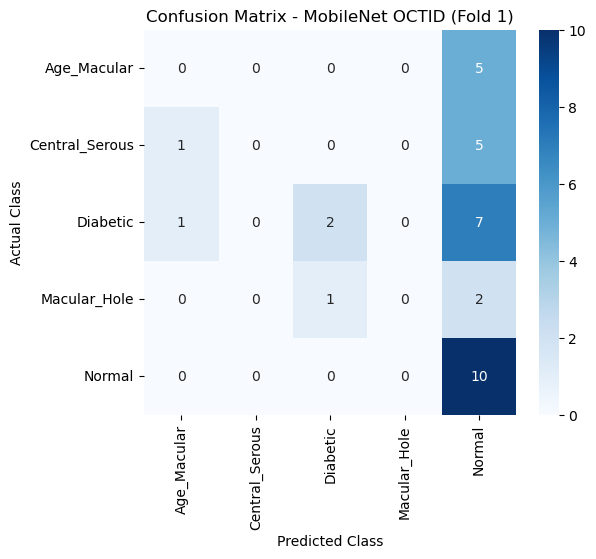


========== Training on Fold 2 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-04-01 04:22:12.071379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1327 - loss: 0.6748  
Epoch 1: val_loss improved from inf to 0.75568, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 26s/step - accuracy: 0.1352 - loss: 0.6919 - val_accuracy: 0.1304 - val_loss: 0.7557
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1414 - loss: 0.6088  
Epoch 2: val_loss improved from 0.75568 to 0.51423, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.1469 - loss: 0.6041 - val_accuracy: 0.1304 - val_loss: 0.5142
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.1502 - loss: 0.5382
Epoch 3: val_loss improved from 0.51423 to 0.35679, saving model to /Users/mananmath

2025-04-01 04:24:56.067616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

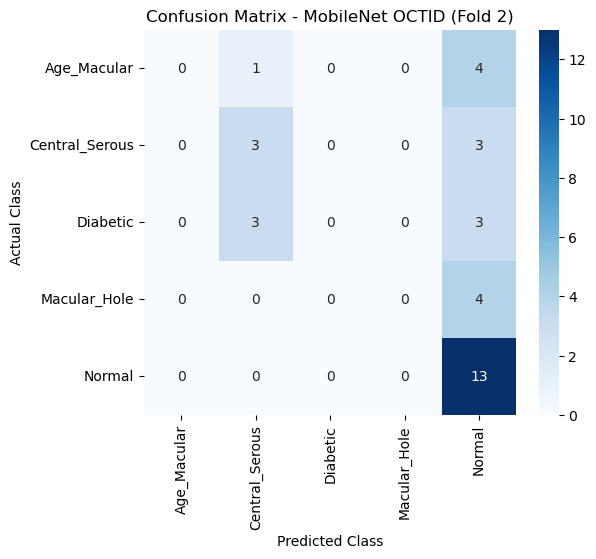


========== Training on Fold 3 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-04-01 04:24:57.045718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2722 - loss: 0.5811  
Epoch 1: val_loss improved from inf to 0.38246, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_3.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 229s 205s/step - accuracy: 0.2692 - loss: 0.5936 - val_accuracy: 0.4348 - val_loss: 0.3825
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2253 - loss: 0.7785
Epoch 2: val_loss did not improve from 0.38246
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.2379 - loss: 0.7609 - val_accuracy: 0.4348 - val_loss: 0.3825
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1765 - loss: 0.7203
Epoch 3: val_loss did not improve from 0.38246
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step - accuracy: 0.1937 - loss: 0.6988 - val_accuracy: 0.4348 - val_loss: 0.3825
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.1727 - loss: 0.7044
Epoch 4: val_

2025-04-01 04:31:16.517237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

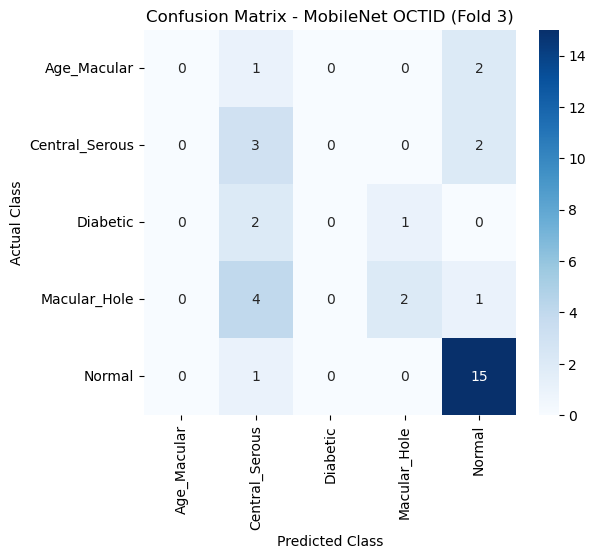


========== Training on Fold 4 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-04-01 04:31:18.075313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.0858 - loss: 0.8047 
Epoch 1: val_loss improved from inf to 0.78447, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_4.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 44s/step - accuracy: 0.1040 - loss: 0.7892 - val_accuracy: 0.0870 - val_loss: 0.7845
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1727 - loss: 0.6602
Epoch 2: val_loss did not improve from 0.78447
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1678 - loss: 0.6675 - val_accuracy: 0.0870 - val_loss: 0.7845
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2234 - loss: 0.7102
Epoch 3: val_loss improved from 0.78447 to 0.45128, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_4.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - ac

2025-04-01 04:34:21.206168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


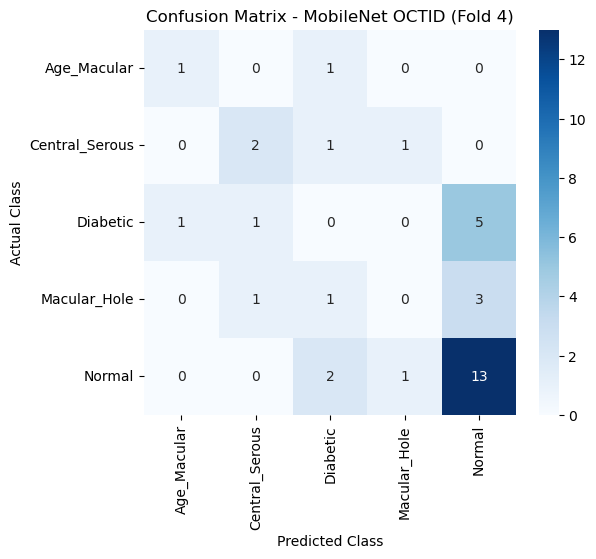


========== Training on Fold 5 ==========
Found 58 files belonging to 5 classes.
Found 24 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-04-01 04:34:22.511900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39s/step - accuracy: 0.1972 - loss: 0.6266 
Epoch 1: val_loss improved from inf to 0.23951, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/models/mobilenet_OCTID_best_fold_5.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 128s 69s/step - accuracy: 0.2004 - loss: 0.6283 - val_accuracy: 0.4167 - val_loss: 0.2395
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2214 - loss: 0.4984
Epoch 2: val_loss did not improve from 0.23951
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.2223 - loss: 0.4948 - val_accuracy: 0.1250 - val_loss: 0.3554
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.1245 - loss: 0.5479
Epoch 3: val_loss did not improve from 0.23951
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.1347 - loss: 0.5370 - val_accuracy: 0.1250 - val_loss: 0.3313
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2355 - loss: 0.4586
Epoch 4: val_l

2025-04-01 04:38:15.807542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mananmathur/anaconda3/envs/oct_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is il

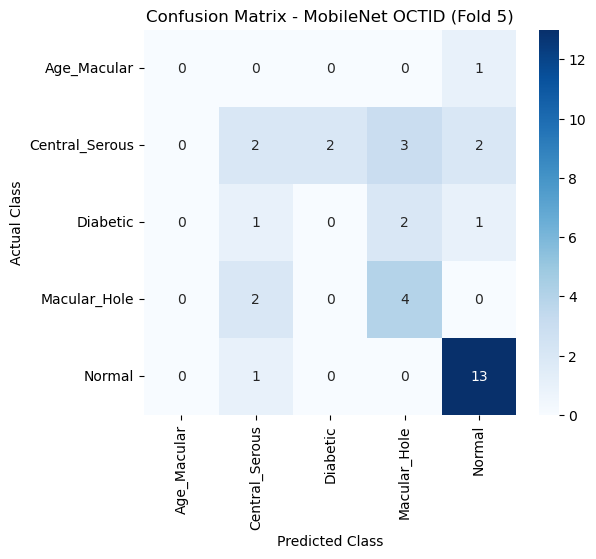

✅ All results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/mobileNet/octid/results/mobilenet_OCTID_5CV_results.xlsx


: 

In [8]:
# MobileNet - OCTID - 5CV
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Disable GPU if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Enable Mixed Precision for Faster Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Paths
dataset_base_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/dataset split/OCTID_Splits"
logs_base_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV"

# Create the necessary directories  <--- Start of the changes
mobilenet_dir = os.path.join(logs_base_path, "mobileNet", "octid")
os.makedirs(mobilenet_dir, exist_ok=True)
os.makedirs(os.path.join(mobilenet_dir, "training"), exist_ok=True)
os.makedirs(os.path.join(mobilenet_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(mobilenet_dir, "results"), exist_ok=True)

logs_path = os.path.join(mobilenet_dir, "training")
models_path = os.path.join(mobilenet_dir, "models")
results_path = os.path.join(mobilenet_dir, "results")

# Hyperparameters
image_size = 224
batch_size = 32
num_classes = 5
epochs = 20

# Prepare results storage
all_results = []

for i in range(1, 6):
    print(f"\n========== Training on Fold {i} ==========")
    
    set_path = os.path.join(dataset_base_path, f"OCTID_Set_{i}")
    train_dir, val_dir, test_dir = [os.path.join(set_path, x) for x in ["Train", "Validation", "Test"]]
    
    # Load datasets
    train_data = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size))
    val_data = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size))
    test_data = tf.keras.utils.image_dataset_from_directory(test_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size), shuffle=False)
    
    # Compute Class Weights
    labels = np.concatenate([y.numpy() for _, y in train_data])
    class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=np.argmax(labels, axis=1))
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Load Pretrained MobileNetV2
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    # Compile Model
    model.compile(optimizer=Adam(learning_rate=3e-4), loss=CategoricalFocalCrossentropy(from_logits=False), metrics=["accuracy"])
    
    # Callbacks
    model_save_path = os.path.join(models_path, f"mobilenet_OCTID_best_fold_{i}.keras")
    callbacks = [
        ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
        CSVLogger(os.path.join(logs_path, f"mobilenet_OCTID_fold_{i}.csv"), append=True)
    ]
    
    # Train Model
    model.fit(train_data, validation_data=val_data, epochs=epochs, class_weight=class_weight_dict, callbacks=callbacks)
    
    # Evaluate on Test Set
    test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
    
    # Predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = np.concatenate([y.numpy() for _, y in test_data])
    
    # Compute Metrics
    cm = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)
    report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=train_data.class_names, output_dict=True)
    
    # Store Results
    all_results.append({
        "Fold": i,
        "Test Accuracy": test_accuracy,
        "Test Loss": test_loss,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.class_names, yticklabels=train_data.class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title(f"Confusion Matrix - MobileNet OCTID (Fold {i})")
    plt.show()

# Save All Results to Excel
results_df = pd.DataFrame(all_results)
results_excel_file = os.path.join(results_path, "mobilenet_OCTID_5CV_results.xlsx")
results_df.to_excel(results_excel_file, index=False)
print(f"✅ All results saved to {results_excel_file}")



========== Training on Fold 1 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-03-31 23:38:24.096527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1483 - loss: 0.3723 
Epoch 1: val_loss improved from inf to 0.28928, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 33s/step - accuracy: 0.1457 - loss: 0.3709 - val_accuracy: 0.1304 - val_loss: 0.2893
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.1902 - loss: 0.3281
Epoch 2: val_loss improved from 0.28928 to 0.22885, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.1912 - loss: 0.3185 - val_accuracy: 0.3913 - val_loss: 0.2288
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.4400 - loss: 0.2113
Epoch 3: val_loss improved from 0.22885 to 0.19793, saving model to /User

2025-03-31 23:43:01.951456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


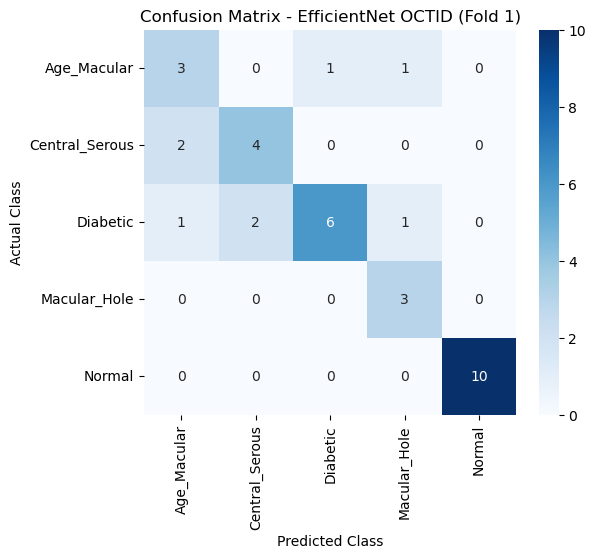


========== Training on Fold 2 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-03-31 23:43:03.420770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4400 - loss: 0.2756 
Epoch 1: val_loss improved from inf to 0.19444, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 83s 36s/step - accuracy: 0.4512 - loss: 0.2815 - val_accuracy: 0.5217 - val_loss: 0.1944
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5376 - loss: 0.2403
Epoch 2: val_loss improved from 0.19444 to 0.17028, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_2.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.5397 - loss: 0.2401 - val_accuracy: 0.6087 - val_loss: 0.1703
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4975 - loss: 0.2245
Epoch 3: val_loss improved from 0.17028 to 0.15564, saving model to /Users/m

2025-03-31 23:45:56.806997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


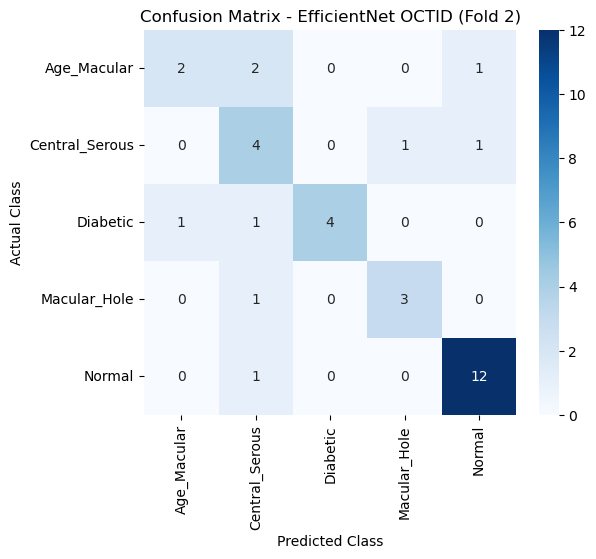


========== Training on Fold 3 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-03-31 23:45:57.934297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2166 - loss: 0.4459  
Epoch 1: val_loss improved from inf to 0.22005, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_3.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 178s 155s/step - accuracy: 0.2262 - loss: 0.4270 - val_accuracy: 0.3913 - val_loss: 0.2201
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2741 - loss: 0.2805
Epoch 2: val_loss improved from 0.22005 to 0.18472, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_3.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 10s/step - accuracy: 0.2822 - loss: 0.2866 - val_accuracy: 0.4783 - val_loss: 0.1847
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.3492 - loss: 0.2687
Epoch 3: val_loss improved from 0.18472 to 0.16551, saving model to /Use

2025-03-31 23:52:05.819544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


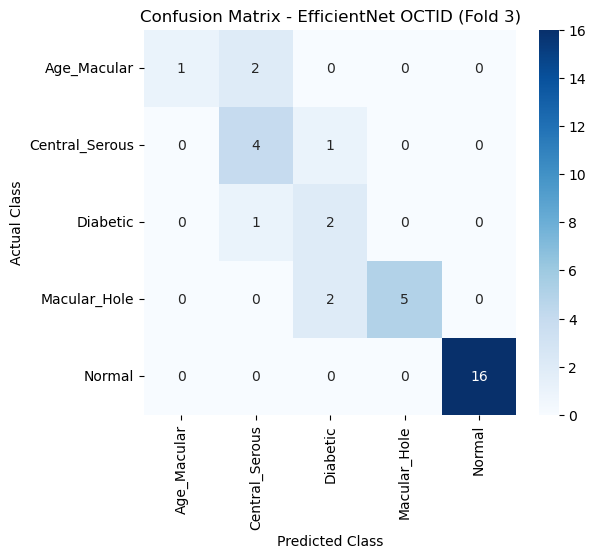


========== Training on Fold 4 ==========
Found 57 files belonging to 5 classes.
Found 23 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-03-31 23:52:07.234368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.1727 - loss: 0.3787  
Epoch 1: val_loss improved from inf to 0.21748, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_4.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 70s 28s/step - accuracy: 0.1678 - loss: 0.3810 - val_accuracy: 0.5217 - val_loss: 0.2175
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.2760 - loss: 0.3206
Epoch 2: val_loss improved from 0.21748 to 0.16447, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_4.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2951 - loss: 0.3075 - val_accuracy: 0.5652 - val_loss: 0.1645
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4468 - loss: 0.3176
Epoch 3: val_loss improved from 0.16447 to 0.13971, saving model to /User

2025-03-31 23:54:42.394599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


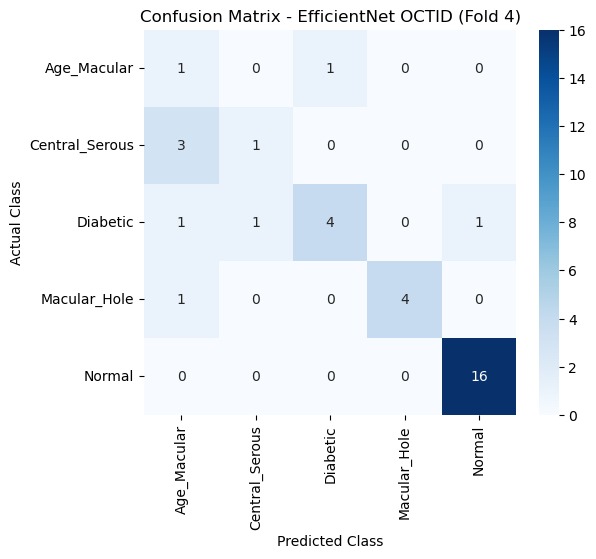


========== Training on Fold 5 ==========
Found 58 files belonging to 5 classes.
Found 24 files belonging to 5 classes.
Found 34 files belonging to 5 classes.


2025-03-31 23:54:43.547479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2543 - loss: 0.3509 
Epoch 1: val_loss improved from inf to 0.22944, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_5.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 32s/step - accuracy: 0.2557 - loss: 0.3489 - val_accuracy: 0.3333 - val_loss: 0.2294
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2387 - loss: 0.3026
Epoch 2: val_loss improved from 0.22944 to 0.19477, saving model to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/models/efficientNet_OCTID_best_fold_5.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.2453 - loss: 0.2940 - val_accuracy: 0.5833 - val_loss: 0.1948
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.4655 - loss: 0.1943
Epoch 3: val_loss improved from 0.19477 to 0.16519, saving model to /Users/m

2025-03-31 23:58:51.827972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


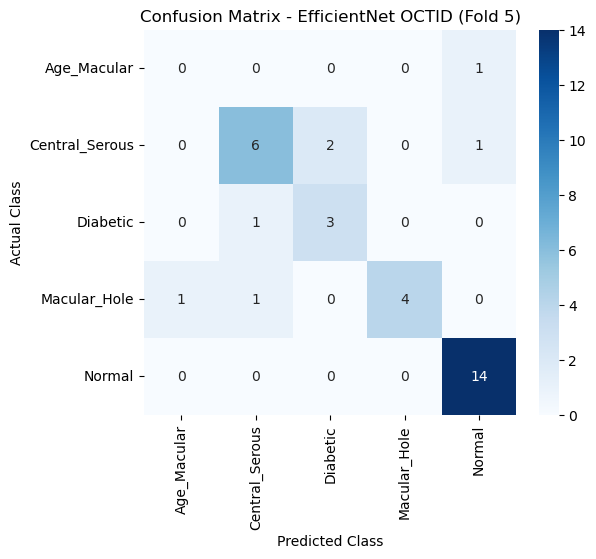

✅ All results saved to /Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV/efficientNet/octid/results/efficientNet_OCTID_5CV_results.xlsx


In [7]:
# EfficientNet - OCTID - 5CV
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Disable GPU if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Enable Mixed Precision for Faster Training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Paths
dataset_base_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/dataset split/OCTID_Splits"
logs_base_path = "/Users/mananmathur/Documents/Academics/MIT/subject matter/YEAR 4/SEM 8/PROJECT/project/logs/5CV"

# Create the necessary directories  <--- Start of the changes
efficientnet_dir = os.path.join(logs_base_path, "efficientNet", "octid")
os.makedirs(efficientnet_dir, exist_ok=True)
os.makedirs(os.path.join(efficientnet_dir, "training"), exist_ok=True)
os.makedirs(os.path.join(efficientnet_dir, "models"), exist_ok=True)
os.makedirs(os.path.join(efficientnet_dir, "results"), exist_ok=True)

logs_path = os.path.join(efficientnet_dir, "training")
models_path = os.path.join(efficientnet_dir, "models")
results_path = os.path.join(efficientnet_dir, "results")

# Hyperparameters
image_size = 224
batch_size = 32
num_classes = 5
epochs = 20

# Prepare results storage
all_results = []

for i in range(1, 6):
    print(f"\n========== Training on Fold {i} ==========")
    
    set_path = os.path.join(dataset_base_path, f"OCTID_Set_{i}")
    train_dir, val_dir, test_dir = [os.path.join(set_path, x) for x in ["Train", "Validation", "Test"]]
    
    # Load datasets
    train_data = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size))
    val_data = tf.keras.utils.image_dataset_from_directory(val_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size))
    test_data = tf.keras.utils.image_dataset_from_directory(test_dir, label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size), shuffle=False)
    
    # Compute Class Weights
    labels = np.concatenate([y.numpy() for _, y in train_data])
    class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=np.argmax(labels, axis=1))
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Load Pretrained EfficientNet
    base_model = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    # Compile Model
    model.compile(optimizer=Adam(learning_rate=3e-4), loss=CategoricalFocalCrossentropy(from_logits=False), metrics=["accuracy"])
    
    # Callbacks
    model_save_path = os.path.join(models_path, f"efficientNet_OCTID_best_fold_{i}.keras")
    callbacks = [
        ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
        CSVLogger(os.path.join(logs_path, f"efficientNet_OCTID_fold_{i}.csv"), append=True)
    ]
    
    # Train Model
    model.fit(train_data, validation_data=val_data, epochs=epochs, class_weight=class_weight_dict, callbacks=callbacks)
    
    # Evaluate on Test Set
    test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
    
    # Predictions
    predictions = model.predict(test_data)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = np.concatenate([y.numpy() for _, y in test_data])
    
    # Compute Metrics
    cm = confusion_matrix(np.argmax(true_labels, axis=1), predicted_classes)
    report = classification_report(np.argmax(true_labels, axis=1), predicted_classes, target_names=train_data.class_names, output_dict=True)
    
    # Store Results
    all_results.append({
        "Fold": i,
        "Test Accuracy": test_accuracy,
        "Test Loss": test_loss,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_data.class_names, yticklabels=train_data.class_names)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title(f"Confusion Matrix - EfficientNet OCTID (Fold {i})")
    plt.show()

# Save All Results to Excel
results_df = pd.DataFrame(all_results)
results_excel_file = os.path.join(results_path, "efficientNet_OCTID_5CV_results.xlsx")
results_df.to_excel(results_excel_file, index=False)
print(f"✅ All results saved to {results_excel_file}")
